In [1]:
import os
import functools
from itertools import groupby
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from codon_hamiltonian import *

---
# Toy Model 

test input

In [2]:
#spike_sars2_seq = 'MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT'
A0A2U1LIM9 = 'MQSTTSVKLSPFDLMTALLNGKVSFDTSNTSDTNIPLAVFMENRELLMILTTSVAVLIGCVVVLVWRRSSSAAKKAAESPVIVVPKKVTEDEVDDGRKKVTVFFGTQTGTAEGFAKALVEEAKARYEKAVFKVIDLDDYAAEDDEYEEKLKKESLAFFFLATYGDGEPTDNAARFYKWFTEGEEKGEWLEKLQYAVFGLGNRQYEHFNKIAKVVDEKLVEQGAKRLVPVGMGDDDQCIEDDFTAWKELVWPELDQLLRDEDDTSVATPYTAAVAEYRVVFHDKPETYDQDQLTNGHAVHDAQHPCRSNVAVKKELHSPLSDRSCTHLEFDISNTGLSYETGDHVGVYVENLSEVVDEAEKLIGLPPHTYFSVHTDNEDGTPLGGASLPPPFPPCTLRKALASYADVLSSPKKSALLALAAHATDSTEADRLKFLASPAGKDEYAQWIVASHRSLLEVMEAFPSAKPPLGVFFASVAPRLQPRYYSISSSPKFAPNRIHVTCALVYEQTPSGRVHKGVCSTWMKNAVPMTESQDCSWAPIYVRTSNFRLPSDPKVPVIMIGPGTGLAPFRGFLQERLAQKEAGTELGTAILFFGCRNRKVDFIYEDELNNFVETGALSELVTAFSREGATKEYVQHKMTQKASDIWNLLSEGAYLYVCGDAKGMAKDVHRTLHTIVQEQGSLDSSKAELYVKNLQMAGRYLRDVW'
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'

In [3]:
amino_seq = fragmenting_amino_acid_seq(HPDF_amino, 3, 0)
codon_seq = Amino_acid_to_Codon(amino_seq)
print('Amino acid seq:', amino_seq)
print('All possible codons:', codon_seq())

Amino acid seq: EGP
All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU']]


Preparing H_codon

In [4]:
#weight_params = {'c_f': -0.1, 'c_GC': 1, 'c_R': 0.1, 'c_L': 1, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 1, 'infty': 10}
#weight_params = {'c_f': 0, 'c_GC': 1, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.00, 'rho_T': 0.5, 'epsilon': 0, 'infty': 0}
weight_params = {'c_f': 0, 'c_GC': 1, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
H_codon = Codon_Hamiltonian(amino_seq, weight_params)

## 1. Exact Diagonalization

Constructing Ising model from QUBO & Running 

In [5]:
J, h, const = H_codon.Q_to_Jh()

In [6]:
tests = Quantum_Ising(J=J, h=h, shift=const)
tests.hamiltonian

array([[-3.5308642 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -5.7037037 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -5.75308642, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 21.18518519,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        21.58024691,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 32.44444444]])

In [10]:
tests.run_ExactDiag()
tests.get_outcome()

{'|1000011000>': 1.0,
 '|1010001000>': 1.0,
 '|1000010001>': 1.0,
 '|1010000001>': 1.0}

## 2. DWaveSampler

Constructing Q_{ij} as dict type

In [53]:
Q = H_codon.get_Q_dict()

### Simulation

In [54]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

#import matplotlib
#matplotlib.use("agg")
#from matplotlib import pyplot as plt

In [55]:
# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
#이건 우리가 최적화 해야할듯?
chainstrength = 15 #min: 12
numruns = 10000

In [56]:
# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_qubo(Q,
                               #chain_strength=chainstrength,
                               num_reads=numruns,
                               #num_spin_reversal_tramsforms=50,
                               label='Codon_sequence')

In [57]:
def get_min_res(response):
    min_E = min(response.data(fields=['energy']))[0]
    
    min_indices = []
    for i, x in enumerate(response.data(fields=['energy'])):
        if x == min_E:
            min_indices.append(i) 
        else: 
            break

    sample_list = np.array(list(response.data(fields=['sample'])))[:,0]
    min_sample_list = sample_list[min_indices]

    min_samples = []
    for x in min_indices:
        a_min_sample = [k for k,v in min_sample_list[x].items() if v == 1]
        if a_min_sample not in min_samples: #remove duplicates of min_sample
            min_samples.append(a_min_sample) 
    
    return min_samples, min_E

In [97]:
#get_min_res(response)

In [59]:
def get_min_res1(response): #more effective for memory usage
    min_E = min(response.data(fields=['energy']))[0]

    min_indices = []
    for i, x in enumerate(response.data(fields=['energy'])):
        if x == min_E:
            min_indices.append(i) 
        else: 
            break

    min_samples = []
    i_min = 0
    for x in response.data(fields=['sample']):
        a_min_sample = [k for k,v in x[0].items() if v == 1]
        if a_min_sample not in min_samples: #remove duplicates of min_sample
            min_samples.append(a_min_sample) 
            
        if i_min == min_indices[-1]:
            break
        else:
            i_min += 1

    return min_samples, min_E

In [98]:
#get_min_res1(response)[0]

In [67]:
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:^15s}{:^15s}'.format(str(S1),str(E),str(int(-1*E))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
[0, 3, 6, 10, 15]-10.250000000000004      10       
[0, 4, 9, 10, 16]-10.250000000000004      10       
[1, 5, 6, 13, 16]-10.250000000000004      10       
[0, 4, 6, 13, 16]-10.250000000000004      10       
[1, 2, 6, 13, 15]-10.250000000000004      10       
[1, 2, 9, 13, 15]-10.250000000000004      10       
[1, 5, 6, 10, 15]-10.250000000000004      10       
[0, 4, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 13, 16]-10.250000000000004      10       
[1, 2, 6, 10, 15]-10.250000000000004      10       
[0, 4, 6, 10, 15]-10.250000000000004      10       
[1, 2, 9, 10, 15]-10.250000000000004      10       
[1, 2, 6, 10, 15]-10.250000000000004      10       
[0, 3, 6, 13, 15]-10.250000000000004      10       
[0, 4, 9, 13, 15]-10.250000000000004 

new $\mathcal{H}_L$

[0, 2, 3, 11, 16, 17, 25]-7.537854785825701 <br>
[0, 2, 4, 11, 15, 17, 25]-7.527818748163343  <br>

[0, 2, 8, 12, 15, 17, 25, 28]-8.02910625876468

[0, 2, 3, 11, 15, 17, 25]-6.592669715640199        <br>

[0, 2, 3, 11, 15, 17, 25, 28]-7.150419551458638  <br>
[0, 2, 3, 11, 15, 17, 24, 28]-7.0986156153496704       <br>
[0, 2, 4, 11, 15, 17, 25, 28]-7.085933946922571  <br>
[0, 2, 4, 11, 15, 17, 24, 28]-7.034130010813604 

In [11]:
H_codon.list_all_possible_codons

[['AUG'],
 ['CAA', 'CAG'],
 ['AGC', 'AGU', 'UCA', 'UCC', 'UCG', 'UCU'],
 ['ACA', 'ACC', 'ACG', 'ACU']]

In [12]:
H_codon.run_Dwave()

([0, 2, 3, 11], -4.948192389640039)

In [14]:
H_codon.opt_codon_seq(base='DNA')

['ATG', 'CAG', 'AGC', 'ACG']

---
# Run Simulator

In [2]:
HPDF_amino = 'EGPALRRSYWRHLRRLVLGPPEPPFSHVCQVGDPVLRGVAAPVERAQLGGPELQRLTQRLVQVMRRRRCVGLSAPQLGVPRQVLALELPEALCRECPPRQRALRQMEPFPLRVFVNPSLRVLDSRLVTFPEGCESVAGFLACVPRFQAVQISGLDPNGEQVVWQASGWAARIIQHEMDHLQGCLFIDKMDSRTFTNVYWMKVND'
print('Length of full seq:', len(HPDF_amino))

Length of full seq: 204


## ED

### 1. Run all

In [3]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.001, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [ ]:
block_size = 2
verbose = 0

aminoacid_block = []
ED_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)
        
    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================
    
    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    J, h, const = H_codon.Q_to_Jh()
    #run Exact Diagonalization
    H_codon = Quantum_Ising(J=J, h=h, shift=const)
    H_codon.run_ExactDiag()
    select_q1 = H_codon.get_outcome(types='list')
    opt_codon_frag = codon_fragment(select_q1[0])
    
    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)


    aminoacid_block.append(amino_fragment)
    ED_codons.append(opt_codon_frag)
    min_E_list.append(H_codon.ground_energy)


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

opt_codon_list = ["".join(ED_codons[x]) for x in range(len(ED_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy


### 2. Run_ED for just one frag

#### TEST1:  Codon Usage Frequency

$c_f = 1$ is fixed. <br>
$\infty = 2 * \epsilon$ <br>
block size = $\epsilon$


In [13]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
# epsilon

In [14]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCG', 'GCG']
-12.329804609399421


#### TEST2: GC Contents

In [144]:
weight_params = {'c_f': 0, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [145]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCU', 'GCU']
['CCU', 'GCA']
['CCA', 'GCU']
['CCA', 'GCA']
-15.65625


#### TEST3: Codon Usage Frequency + GC Contents

In [142]:
weight_params = {'c_f': 0.1, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}

In [143]:
block_size = 2
block_position = 1

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
J, h, const = H_codon.Q_to_Jh()
H_codon_matrix = Quantum_Ising(J=J, h=h, shift=0) #shift=const
H_codon_matrix.run_ExactDiag()

# Pick sites where qubit=1
select_q1 = H_codon_matrix.get_outcome(types='list')

# outcome All optimal codon seqs
print('=> All optimal codons:')
for x in select_q1:
    print(codon_fragment(x))

print(H_codon_matrix.ground_energy)

=> Amino acids: PA
=> All possible codons: [['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU']]
=> All optimal codons:
['CCA', 'GCA']
-15.932745517428106


## D-wave

### 1. Run_Dwave for just one frag

#### TEST1: Codon Usage Frequency

In [11]:
weight_params = {'c_f': 1, 'c_GC': 0, 'c_R': 0, 'rho_T': 0.5, 'epsilon': 2, 'infty': 4}
# epsilon

In [12]:
block_size = 2
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment())


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
min_samples, min_E = H_codon.run_Dwave()
print("=> opt_codons:", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EG
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU']]
=> opt_codons: [['GAA', 'GGC']]
=> minimum energy: -2.737338199325384
=> CAI: [1.0]
=> GC average: [66.66666666666667]


#### TEST2: GC Contents

In [13]:
weight_params = {'c_f': 0, 'c_GC': 10, 'c_R': 0, 'c_L': 0, 'epsilon_f': 0.000, 'rho_T': 0.5, 'epsilon': 0, 'infty': 0}
# epsilon

In [16]:
block_size = 2
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EG
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU']]
=> opt_codons(5): [['GGC'], ['GGG'], ['GAA', 'GGU'], ['GAA', 'GAG'], ['GAA', 'GGA']]
=> minimum energy: -2.5
=> CAI: [1.0, 0.3658536585365854, 0.9106416928094864, 0.6702800625998364, 0.5179697702828122]
=> GC average: [100.0, 100.0, 50.0, 50.0, 50.0]


#### TEST3: Minimizing repeated nucleotides

In [39]:
weight_params = {'c_f': 0.01, 'c_GC': 0, 'c_R': 0.05, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}
# epsilon

In [40]:
block_size = 5
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EGPAL
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU'], ['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG']]
=> opt_codons(1): [['GAA', 'GGU', 'CCG', 'GCG', 'CUG']]
=> minimum energy: -9.512004499567093
=> CAI: [0.9632499875338506]
=> GC average: [73.33333333333333]


In [37]:
H_codon.outcome_codon_seq()[25]

['GAA', 'GGU', 'CCG', 'GCA', 'CUG']

In [34]:
[CAI_ec(c) for c in codon_seq_list][25]

0.8648133215622051

In [35]:
GC_average(codon_seq_list)[25]

66.66666666666667

#### TEST4: Codon Usage Frequency + GC Contents + Min repeated nucleotides

In [5]:
weight_params = {'c_f': 0.01, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}
block_size = 5
block_position = 0
# epsilon

In [20]:
weight_params = {'c_f': 0.1, 'c_GC': 10, 'c_R': 0.00, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}

In [21]:
block_size = 8
block_position = 0

amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, block_position)
print('=> Amino acids:', amino_fragment)
codon_fragment = Amino_acid_to_Codon(amino_fragment)
print('=> All possible codons:', codon_fragment());


H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
_, min_E = H_codon.run_Dwave()
print("=> opt_codons("+str(len(H_codon.outcome_codon_seq()))+"):", H_codon.outcome_codon_seq())
print("=> minimum energy:", min_E)

CAI_ec = CAIs("ecoli")
codon_seq_list = ["".join(c) for c in H_codon.outcome_codon_seq()]
print("=> CAI:", [CAI_ec(c) for c in codon_seq_list])
print("=> GC average:",GC_average(codon_seq_list))

=> Amino acids: EGPALRRS
=> All possible codons: [['GAA', 'GAG'], ['GGA', 'GGC', 'GGG', 'GGU'], ['CCA', 'CCC', 'CCG', 'CCU'], ['GCA', 'GCC', 'GCG', 'GCU'], ['CUA', 'CUC', 'CUG', 'CUU', 'UUA', 'UUG'], ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGU'], ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGU'], ['AGC', 'AGU', 'UCA', 'UCC', 'UCG', 'UCU']]
=> opt_codons(1): [['GAA', 'GGA', 'CCG', 'GCG', 'CUG', 'CGU', 'CGU', 'UCU']]
=> minimum energy: -18.679525222303788
=> CAI: [0.7746823446913669]
=> GC average: [66.66666666666667]


### 2. Fully run

In [18]:
weight_params = {'c_f': 0.05, 'c_GC': 10, 'c_R': 0.01, 'rho_T': 0.6, 'epsilon': 2, 'infty': 4}

In [19]:
block_size = 20
verbose = 0

aminoacid_block = []
dwave_opt_codons = []
min_E_list = []

print("* Running", end=' ') if verbose == 0 else None
for ith in range(len(HPDF_amino) // block_size + 1):
    amino_fragment = fragmenting_amino_acid_seq(HPDF_amino, block_size, ith)
    codon_fragment = Amino_acid_to_Codon(amino_fragment)

    if verbose >= 1:
        print('In amino acide seq, Run Block:',str(ith))
        print('=> Amino acids:', amino_fragment)
    if verbose >= 2:
        print('=> All possible codons:', codon_fragment())
    #====================

    #construct H_codon
    H_codon = Codon_Hamiltonian(amino_fragment, weight_params)
    #run Dwave Sampler
    min_sample, min_E = H_codon.run_Dwave() #chain_strength=15
    opt_codon_frag = H_codon.outcome_codon_seq()

    #====================
    if verbose ==0:
        print(".", end=' ')
    elif verbose >= 2:
        print('=> Ground states:', min_sample)
    elif verbose >= 1:
        print('=> Optimal codons:', opt_codon_frag)



    aminoacid_block.append(amino_fragment)
    dwave_opt_codons.append(opt_codon_frag[0])
    min_E_list.append(min_E)


* Running . . . . . . . . . . . 

#### Outcomes

In [5]:
dwave_opt_codon_list = ["".join(dwave_opt_codons[x]) for x in range(len(dwave_opt_codons))]
rslt_df = pd.DataFrame(list(zip(aminoacid_block, dwave_opt_codon_list, min_E_list)),
                        columns=['amino acid', 'codon', "Energy"])
rslt_df

,amino acid,codon,Energy
0,EGPAL,GAAGGUCCGGCACUG,-13.248628
1,RRSYW,CGUCGCAGCUAUUGG,-13.384052
2,RHLRR,CGUCAUCUGCGUCGU,-13.392099
3,LVLGP,CUGGUGUUAGGUCCG,-13.207935
4,PEPPF,CCGGAACCGCCGUUU,-13.243665
5,SHVCQ,AGCCACGUGUGUCAG,-13.351852
6,VGDPV,GUUGGUGAUCCGGUG,-13.254148
7,LRGVA,CUGCGUGGUGUAGCA,-13.230135
8,APVER,GCACCGGUUGAACGU,-13.235938
9,AQLGG,GCGCAGUUAGGUGGU,-13.227486


#### Save

In [6]:
DNA='HPDF'
filepath=f'./result_data/'
os.makedirs(filepath, exist_ok=True)


file_name = f'{DNA}_bs{block_size}'
for key, val in weight_params.items():
    file_name += '_' + key + str(val)
file_name += '.csv'


rslt_df.to_csv(os.path.join(filepath, file_name))

#### Metrics

In [7]:
dwave_codon_RNA = "".join(rslt_df['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

In [8]:
#CAI
CAI_hu = CAIs("human")
CAI_ec = CAIs("ecoli")

CAI_hu(dwave_codon_DNA)
CAI_ec(dwave_codon_DNA)

print("-"*30)
print(f"dwave_codon (block-size:{block_size})")
print(f"CAI of dwave_codon for human : {CAI_hu(dwave_codon_DNA)}")
print(f"CAI of dwave_codon for ecoli : {CAI_ec(dwave_codon_DNA)}")

#GC
from Bio.SeqUtils import GC
GC_dwave = GC(dwave_codon_DNA)
print(f"GC of dwave_codon : {GC_dwave}")

------------------------------
dwave_codon (block-size:5)
CAI of dwave_codon for human : 0.6709249130677576
CAI of dwave_codon for ecoli : 0.8384396179093649
GC of dwave_codon : 60.294117647058826


#### GC average in the window

In [9]:
def getGCDistribution(sequence : str, window=30) -> list : 
    seq_chunks = [sequence[i:i+window] for i in range(len(sequence)-window)]
    assert len(seq_chunks) == len(sequence) - window
    GC_li = []
    for seqC in seq_chunks:
        GC_li.append(GC(seqC))
    
    return GC_li

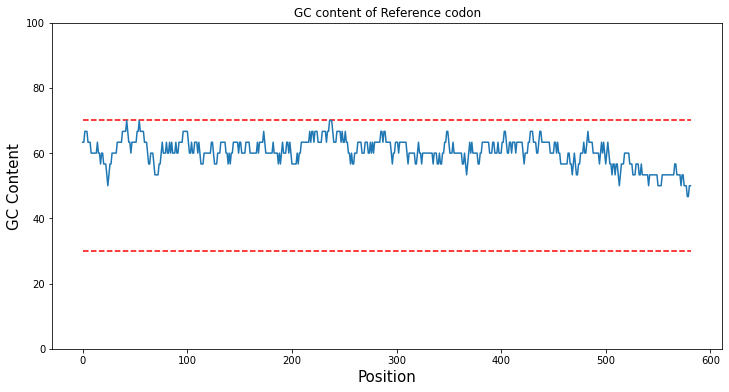

In [10]:
GCd_ref = getGCDistribution(dwave_codon_DNA) 

plt.figure(figsize=(12,6))
plt.ylabel("GC Content", fontsize=15)
plt.xlabel("Position", fontsize=15)
plt.ylim([0,100])
plt.hlines(y=30,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')
plt.hlines(y=70,xmin=0,xmax=len(GCd_ref), color='r', linestyles='--')

plt.plot(np.arange(len(GCd_ref)), GCd_ref)
plt.title('GC content of Reference codon')

plt.show()

---
# Results for metrices

### 1. reference codon DNA <br>


In [2]:
ref_codon_DNA = 'GAGGGCCCGGCGCTGCGGCGCTCCTATTGGCGCCACCTGAGGCGTCTGGTGCTGGGTCCTCCCGAACCGCCGTTCTCGCACGTGTGCCAAGTCGGGGACCCGGTGCTGCGCGGCGTGGCGGCCCCGGTGGAGCGGGCGCAGCTAGGCGGGCCCGAGCTGCAGCGGCTGACGCAACGGCTGGTCCAGGTGATGCGGCGGCGGCGCTGCGTGGGCCTAAGCGCGCCGCAGCTGGGGGTGCCGCGGCAGGTGCTGGCGCTGGAGCTCCCCGAGGCGCTGTGTCGGGAGTGCCCGCCCCGCCAGCGCGCGCTCCGCCAAATGGAGCCCTTCCCCCTGCGCGTGTTCGTGAACCCCAGCCTGCGAGTGCTTGACAGCCGCCTGGTCACCTTTCCCGAGGGCTGCGAGAGCGTCGCCGGCTTCCTGGCCTGCGTGCCCCGCTTCCAGGCGGTGCAGATCTCAGGGCTGGACCCCAATGGAGAACAGGTGGTGTGGCAGGCGAGCGGGTGGGCAGCCCGCATCATCCAGCACGAGATGGACCACCTGCAGGGCTGCCTGTTTATTGACAAAATGGACAGCAGGACGTTCACAAACGTCTATTGGATGAAGGTGAATGACTAA'
BiLSTM_codon_DNA = 'GAAGGTCCGGCACTGCGTCGTAGCTATTGGCGTCATCTGCGTCGTCTGGTGCTGGGTCCGCCGGAACCGCCGTTTAGCCACGTGTGCCAGGTCGGCGATCCGGTGCTGCGTGGCGTGGCGGCACCGGTGGAACGTGCGCAGCTGGGCGGTCCGGAACTGCAGCGTCTGACCCAGCGTCTGGTGCAGGTGATGCGTCGTCGTCGTTGCGTCGGTCTGAGCGCACCGCAGCTGGGCGTGCCGCGTCAGGTGCTGGCGCTGGAACTGCCGGAAGCGCTGTGCCGTGAATGCCCGCCGCGTCAGCGTGCGCTGCGTCAGATGGAACCGTTTCCGCTGCGCGTGTTTGTTAACCCGAGCCTGCGCGTGCTGGATAGCCGTCTGGTGACCTTTCCGGAAGGCTGCGAAAGCGTGGCGGGTTTTCTGGCGTGCGTGCCGCGTTTTCAGGCGGTGCAGATTTCCGGTCTGGATCCGAACGGCGAACAGGTGGTGTGGCAGGCGAGCGGCTGGGCGGCGCGTATTATTCAGCATGAAATGGATCATCTGCAGGGCTGCCTGTTTATTGATAAAATGGATAGCCGTACCTTTACCAACGTCTATTGGATGAAAGTGAACGATTAA'
genscript_codon_DNA = 'GAAGGACCCGCTCTAAGGAGATCATATTGGCGCCATCTGAGACGTCTGGTGTTGGGCCCTCCGGAGCCGCCATTCTCCCATGTTTGTCAGGTCGGTGATCCGGTGTTGCGCGGTGTTGCGGCGCCGGTTGAACGTGCGCAGCTGGGCGGTCCGGAGCTGCAACGTCTGACCCAGCGTCTGGTGCAAGTCATGCGTCGCCGTCGCTGCGTTGGTTTGAGCGCACCGCAGCTGGGCGTCCCGCGCCAAGTGTTAGCCCTGGAACTGCCGGAGGCACTTTGCCGTGAGTGCCCGCCACGTCAGCGTGCTCTCCGCCAAATGGAACCGTTCCCGTTGCGCGTGTTCGTGAACCCGTCCCTGCGTGTTCTGGACTCTCGTTTGGTTACCTTTCCGGAGGGCTGTGAAAGCGTTGCCGGTTTTCTGGCGTGCGTGCCGCGTTTTCAGGCTGTGCAAATTAGCGGTCTCGACCCGAATGGTGAACAGGTAGTTTGGCAGGCGAGCGGCTGGGCAGCGCGTATTATCCAACACGAGATGGACCACCTGCAAGGCTGCCTGTTTATCGACAAGATGGATTCGCGTACGTTCACCAACGTGTACTGGATGAAAGTTAACGATTAA'
genwis_codon_DNA = 'GAAGGACCGGCGCTGCGCCGCAGCTATTGGCGCCATTTACGCCGTCTGGTACTGGGCCCGCCGGAACCGCCGTTTTCCCATGTGTGCCAAGTGGGAGATCCGGTGCTTCGCGGAGTCGCGGCGCCGGTGGAACGCGCTCAACTGGGCGGACCCGAATTACAGCGTCTTACCCAACGTCTGGTGCAAGTGATGCGGCGCCGCCGCTGCGTAGGCCTGAGCGCACCACAGCTGGGCGTGCCGCGACAAGTACTGGCACTTGAGTTACCGGAAGCGCTGTGCAGAGAATGTCCGCCTCGTCAGCGCGCGCTGCGTCAGATGGAACCGTTTCCGCTGCGCGTGTTTGTGAACCCGAGCCTGCGCGTGCTGGATAGCCGCCTGGTGACCTTTCCGGAAGGCTGCGAAAGCGTGGCGGGCTTTCTGGCGTGCGTGCCGCGCTTTCAAGCGGTGCAGATTAGCGGCCTGGATCCGAACGGCGAACAAGTGGTGTGGCAAGCGAGCGGCTGGGCGGCGCGCATTATTCAGCATGAAATGGATCATCTGCAAGGCTGCCTGTTTATTGATAAAATGGATAGCCGCACCTTTACCAACGTGTATTGGATGAAAGTGAACGATTAA'


#### Reference codon DNA

ref_codon_DNA
----------------------------------------
CAI for human: 0.7876879260559179
CAI for ecoli: 0.6626674257312732
CPB for human: -0.00934662006966652
CPB for ecoli: -0.11725346452767782
Effective number of codons: 36.42613699652952
Similarity to ref_codon: 1.0
GC: 69.77124183006536
GC3: 87.74509803921569


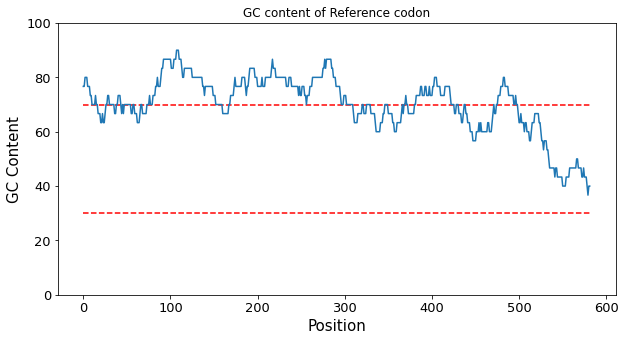

In [3]:
dp_metrics('ref_codon_DNA', ref_codon_DNA[:-3], ref_codon = ref_codon_DNA[:-3])

#### BiLSTM codon DNA

BiLSTM_codon_DNA
----------------------------------------
CAI for human: 0.682288617477938
CAI for ecoli: 0.9662881947629263
CPB for human: -0.1640699042944077
CPB for ecoli: 0.05155453598388932
Effective number of codons: 22.57132616247219
Similarity to ref_codon: 0.826797385620915
GC: 62.745098039215684
GC3: 65.68627450980392


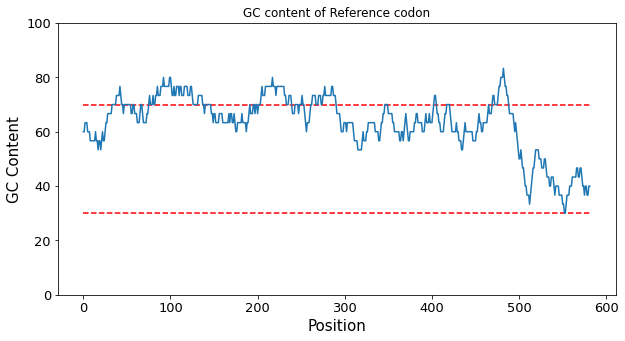

In [4]:
dp_metrics('BiLSTM_codon_DNA', BiLSTM_codon_DNA[:-3], ref_codon = ref_codon_DNA[:-3])

#### Genscript DNA

genscript_codon_DNA
----------------------------------------
CAI for human: 0.6428468577813087
CAI for ecoli: 0.7326141384628243
CPB for human: -0.1637985863116144
CPB for ecoli: -0.08079378205074338
Effective number of codons: 52.0870163894527
Similarity to ref_codon: 0.7941176470588235
GC: 60.130718954248366
GC3: 62.254901960784316


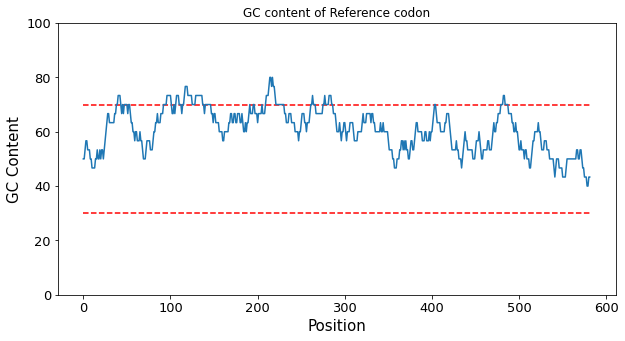

In [3]:
dp_metrics('genscript_codon_DNA', genscript_codon_DNA[:-3], ref_codon = ref_codon_DNA[:-3])

#### Genwis DNA

genwis_codon_DNA
----------------------------------------
CAI for human: 0.6853522125123164
CAI for ecoli: 0.831262679672495
CPB for human: -0.14862889722784567
CPB for ecoli: -0.05242128829062447
Effective number of codons: 25.051319753775385
Similarity to ref_codon: 0.8088235294117647
GC: 61.60130718954248
GC3: 64.2156862745098


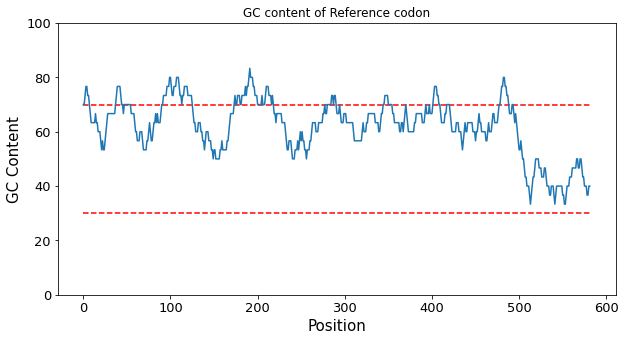

In [6]:
dp_metrics('genwis_codon_DNA', genwis_codon_DNA[:-3], ref_codon = ref_codon_DNA[:-3])

### 2. Dwave codon DNA <br>

#### Block size: 5, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6445381693631448
CAI for ecoli: 0.8715684286745264
CPB for human: -0.08340964568509003
CPB for ecoli: 0.006456326431134485
Effective number of codons: 31.325061869372615
Similarity to ref_codon: 0.8022875816993464
GC: 59.64052287581699
GC3: 57.35294117647059


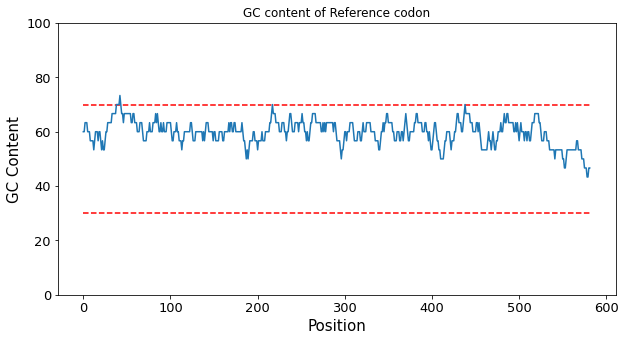

In [8]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs5_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

#### Block size: 5, $c_f=0.05$, $c_{GC}=10$, $c_R=0.01$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6709249130677576
CAI for ecoli: 0.8384396179093649
CPB for human: -0.07297003071691434
CPB for ecoli: 0.018968199506147334
Effective number of codons: 31.880652628352593
Similarity to ref_codon: 0.803921568627451
GC: 60.294117647058826
GC3: 59.80392156862745


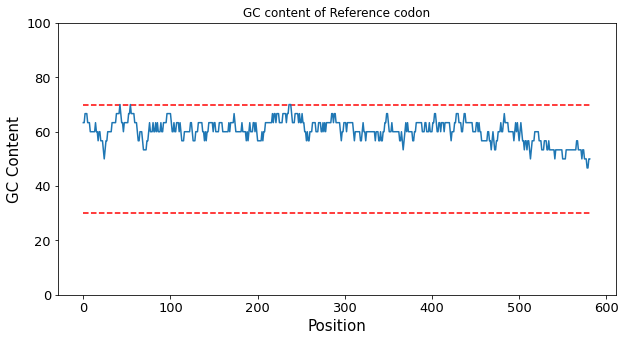

In [9]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs5_c_f0.05_c_GC10_c_R0.01_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

In [12]:
dwave_codon_DNA

'GAAGGTCCGGCACTGCGTCGCAGCTATTGGCGTCATCTGCGTCGTCTGGTGTTAGGTCCGCCGGAACCGCCGTTTAGCCACGTGTGTCAGGTTGGTGATCCGGTGCTGCGTGGTGTAGCAGCACCGGTTGAACGTGCGCAGTTAGGTGGTCCGGAACTGCAGCGTCTGACTCAGCGTCTGGTGCAGGTGATGCGTCGTCGTCGTTGTGTGGGTCTGAGTGCACCGCAGTTAGGTGTGCCGCGTCAGGTGCTGGCACTGGAACTGCCGGAAGCGCTGTGTCGTGAATGTCCACCGCGTCAGCGTGCACTGCGTCAGATGGAACCGTTCCCGCTGCGTGTGTTCGTGAATCCGAGTCTGCGCGTGCTGGATAGTCGCCTGGTTACCTTCCCGGAAGGTTGCGAGAGCGTAGCAGGCTTCCTGGCATGTGTGCCGCGTTTCCAGGCAGTGCAGATCAGCGGCCTGGATCCGAACGGTGAACAGGTAGTGTGGCAGGCATCTGGTTGGGCAGCACGCATCATCCAGCACGAGATGGATCACCTGCAAGGCTGCCTGTTCATCGACAAGATGGACAGTCGCACGTTCACCAACGTGTACTGGATGAAGGTGAACGAC'

#### Block size: 8, $c_f=0.01$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6414828003344591
CAI for ecoli: 0.82267328194055
CPB for human: -0.11619264813245324
CPB for ecoli: 0.018812527862197722
Effective number of codons: 32.60186304898926
Similarity to ref_codon: 0.7843137254901961
GC: 59.31372549019608
GC3: 58.333333333333336


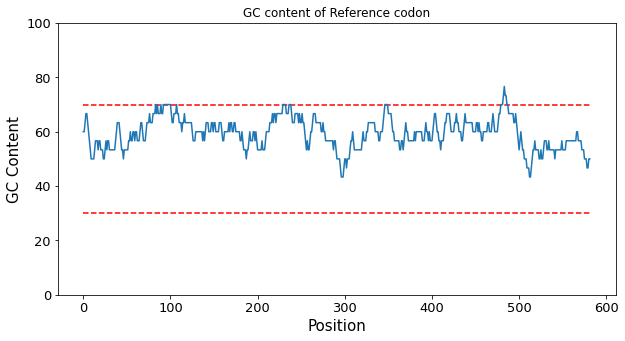

In [10]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.01_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

#### Block size: 8, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6557085196351714
CAI for ecoli: 0.8633182866924429
CPB for human: -0.08196465195494201
CPB for ecoli: -0.001475079234689558
Effective number of codons: 31.388497267327296
Similarity to ref_codon: 0.7843137254901961
GC: 60.78431372549019
GC3: 62.254901960784316


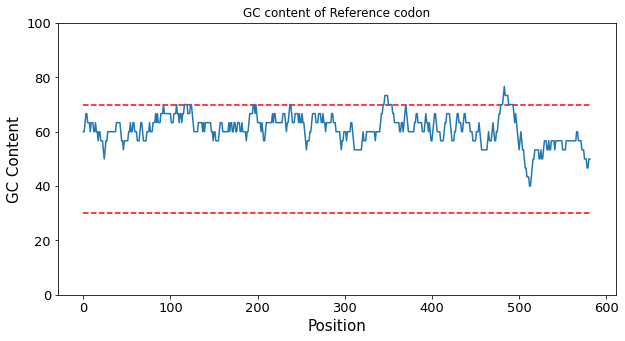

In [11]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

#### Block size: 8, $c_f=0.1$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6850240667911434
CAI for ecoli: 0.8613108293506399
CPB for human: -0.11603828067076119
CPB for ecoli: -0.008886282671451232
Effective number of codons: 36.51946889386342
Similarity to ref_codon: 0.7892156862745098
GC: 60.947712418300654
GC3: 61.27450980392157


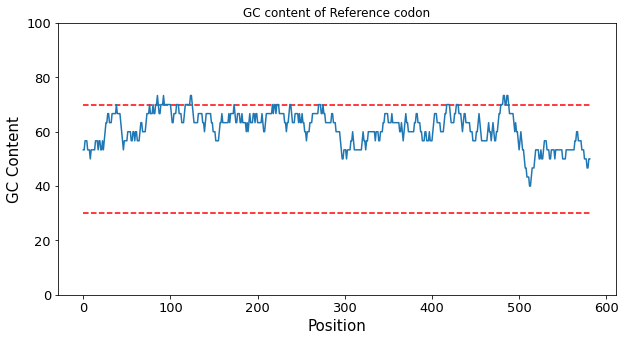

In [12]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs8_c_f0.1_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

#### Block size: 10, $c_f=0.05$, $c_{GC}=10$, $c_R=0$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6542158817696027
CAI for ecoli: 0.8161581437046183
CPB for human: -0.08797082973975251
CPB for ecoli: -0.06236750235306533
Effective number of codons: 38.681397968929225
Similarity to ref_codon: 0.7826797385620915
GC: 60.294117647058826
GC3: 59.80392156862745


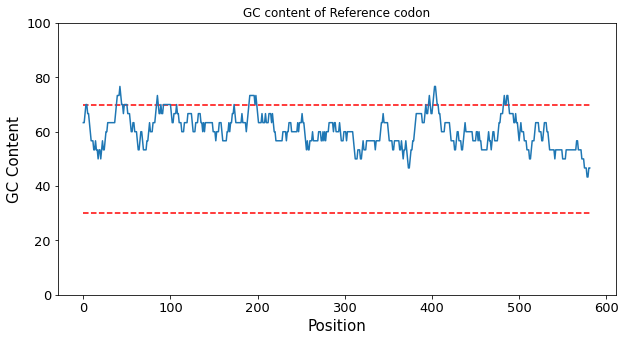

In [13]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs10_c_f0.05_c_GC10_c_R0_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

In [22]:
dwave_codon_DNA

'GAAGGTCCGGCGCTGCGTCGTAGCTATTGGCGGCATTTACGTCGTCTGGTCCTGGGTCCCCCGGAACCGCCGTTTAGCCATGTTTGCCAGGTTGGCGATCCGGTCCTGCGTGGCGTTGCAGCACCGGTAGAACGCGCACAACTGGGTGGCCCAGAACTCCAGCGTCTGACACAGCGTCTGGTGCAGGTTATGCGCCGTCGCCGTTGTGTGGGTCTGTCCGCGCCGCAGTTAGGTGTTCCACGCCAAGTACTGGCGCTGGAACTGCCAGAAGCGCTGTGTCGTGAATGTCCACCTCGTCAGCGTGCACTGCGCCAAATGGAACCGTTTCCGCTGCGTGTCTTTGTGAATCCGTCCCTTCGCGTGCTGGACAGCCGTTTAGTTACCTTCCCGGAAGGTTGCGAAAGCGTGGCGGGCTTCCTGGCGTGCGTTCCGCGTTTTCAAGCGGTGCAGATCAGTGGCCTGGATCCGAATGGCGAACAGGTTGTTTGGCAGGCGTCTGGTTGGGCGGCGCGCATCATTCAGCACGAAATGGACCACCTGCAGGGCTGCCTGTTCATCGACAAAATGGACAGCCGCACCTTCACCAACGTGTATTGGATGAAGGTGAACGAC'

#### Block size: 10, $c_f=0.05$, $c_{GC}=10$, $c_R=0.01$, $\rho_T=0.6$, $\epsilon=2$, $\infty=4$

dwave_codon_DNA
----------------------------------------
CAI for human: 0.6743860498182793
CAI for ecoli: 0.7665748355554213
CPB for human: -0.09383684734835095
CPB for ecoli: -0.020573403019828438
Effective number of codons: 38.19762835823498
Similarity to ref_codon: 0.8006535947712419
GC: 60.62091503267974
GC3: 59.80392156862745


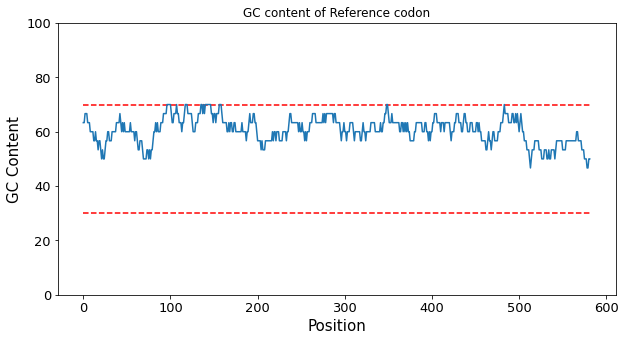

In [14]:
df_opt_codon = pd.read_csv('./result_data/HPDF_bs10_c_f0.05_c_GC10_c_R0.01_rho_T0.6_epsilon2_infty4.csv', index_col=0)
dwave_codon_RNA = "".join(df_opt_codon['codon'])
dwave_codon_DNA = dwave_codon_RNA.replace("U", "T")

dp_metrics('dwave_codon_DNA', dwave_codon_DNA, ref_codon = ref_codon_DNA[:-3])

In [20]:
dwave_codon_DNA

'GAAGGTCCGGCGCTGCGTCGCAGTTATTGGCGTCATCTGCGACGTCTGGTTCTAGGACCACCGGAACCGCCGTTCTCTCATGTCTGTCAGGTTGGTGATCCGGTTCTGCGCGGTGTTGCGGCTCCGGTTGAACGTGCACAGCTGGGCGGTCCAGAACTGCAGCGGCTGACGCAGCGTCTGGTGCAGGTTATGCGTCGACGTCGCTGTGTGGGTCTGAGTGCACCGCAATTAGGTGTTCCGCGTCAGGTGCTGGCACTTGAACTGCCGGAGGCACTGTGTCGTGAGTGTCCACCGCGTCAGCGTGCTCTGCGTCAGATGGAACCGTTCCCTCTCCGCGTCTTCGTGAATCCGAGTCTGCGCGTGCTGGACTCTCGCCTGGTTACCTTCCCGGAAGGCTGTGAGTCAGTCGCTGGCTTCCTGGCATGTGTGCCGCGTTTCCAGGCAGTGCAGATCAGCGGCCTGGATCCGAATGGCGAACAGGTAGTGTGGCAAGCGTCTGGTTGGGCAGCGCGCATCATCCAGCACGAGATGGATCATCTGCAAGGCTGCCTGTTCATCGACAAGATGGACAGCCGCACGTTCACCAACGTGTACTGGATGAAGGTGAACGAC'